# Image Classification 

I have just finished a free Udacity course on image classification problems and wanted to test my new found knowledge on a simple project. So, I explored kaggle until I found a competition that was my skill level. I decided to attempt the Aerial Cactus Identification competition.

# Overview

The focal point of this project is to get your machine to be able to label an image as "having a cactus" or "not having a cactus". I am going to exploit some new techniques and skills I have developed from my online course.

# Table of Content

    1) Import the appropriate packages
    2) Exploritory data analysis
    3) Build out a CNN from scratch (I want to practice and further understand this Deep Learninng Algorithm
    4) Train 
    5) Evaluate
    6) test (I probably wont include my models testing run in this notebook)

## Packages

In [1]:
#data manipulation libraries
import pandas as pd
import numpy as np
import os

#visualization libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

#model building libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

#train/evaulating libraries
from sklearn.model_selection import train_test_split

## Exploritory Data Analysis

First lets bring the data into our python enviroment

In [2]:
#Levearge Pandas to read in the data
labels = pd.read_csv('/Users/connerleavitt/Desktop/Cool-Code/aerial-cactus-identification/train.csv')
sub = pd.read_csv('/Users/connerleavitt/Desktop/Cool-Code/aerial-cactus-identification/sample_submission.csv')
train_path = ('/Users/connerleavitt/Desktop/Cool-Code/aerial-cactus-identification/train')
test_path = ('/Users/connerleavitt/Desktop/Cool-Code/aerial-cactus-identification/test')

Lets start exploring the data by extracting basic yet import information

In [3]:
#print the number of observations in the datasets
print('Num train samples:{0}'.format(len(os.listdir(train_path))))
print('Num test samples:{0}'.format(len(os.listdir(test_path))))

Num train samples:17501
Num test samples:4000


In [4]:
#take a peak at the dataframe
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


next lets find out how many photos are labeled as having a cactus and how many are not

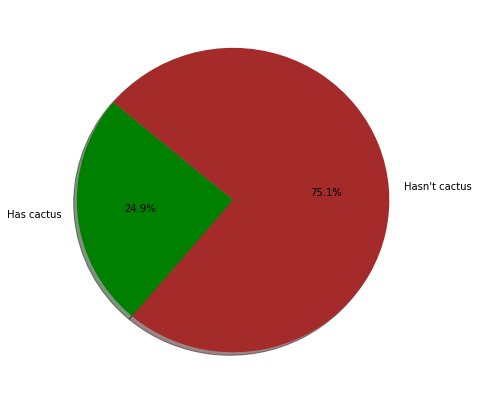

In [5]:
#visualize the balance of the data
lab = 'Has cactus','Hasn\'t cactus'
colors=['green','brown']

plt.figure(figsize=(7,7))
plt.pie(labels.groupby('has_cactus').size(), labels=lab,
        labeldistance=1.1, autopct='%1.1f%%',
        colors=colors,shadow=True, startangle=140)
plt.show()

In [6]:
#Lets a hard count
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

So it appears we have a 1:3 ratio. 1/3 of the photos have a cactus and 2/3 do not

Let's take a look at the photos that do have a cactus and then look at the photos that do not have a cactus. That way we can get a basic understanding of the task we are going to be asking our machines to do for us.

### Has Cactus

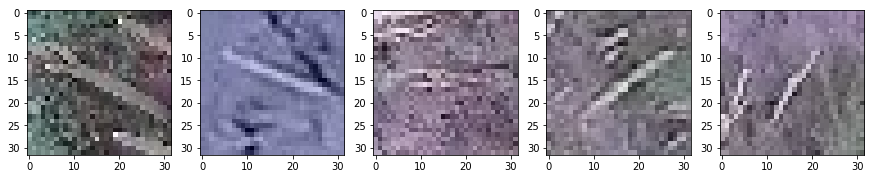

In [7]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

### Does not have cactus

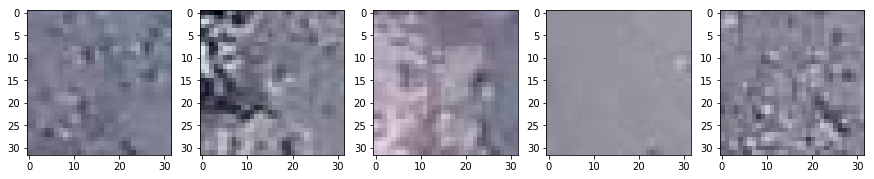

In [8]:
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
  path = os.path.join(train_path,idx)
  ax[i].imshow(cv2.imread(path)) # [...,[2,1,0]]

The data is pretty clean so lets begin the construction of out CNN.

## Modeling

Lets begin by establishing the hyperparameters of our model. Now I did not go through the grueling process of optimizing the hyperparameters but used a Kernal and used his hyperparameters. As many will know there is no point in repeating work that has already been done so research can go a long way in data science/ model building. 

In [9]:
## Parameters for model

# Hyper parameters
num_epochs = 25
num_classes = 2
batch_size = 128
learning_rate = 0.002

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Next I will split my training data into training and validating. This allows me to save my testing data for actual testing. Spliting into a training sample and a validation sample allows me to tweek my model as needed without exposing my model to the data I want to test it on. Because the test data is not labeled it would be impossible to validate unless I went in and hand checked each score

In [10]:
# data splitting
train, val = train_test_split(labels, stratify=labels.has_cactus, test_size=0.1)
#check shape should be 1:3
train.shape, val.shape

((15750, 2), (1750, 2))

In [11]:
train['has_cactus'].value_counts()

1    11822
0     3928
Name: has_cactus, dtype: int64

In [12]:
val['has_cactus'].value_counts()

1    1314
0     436
Name: has_cactus, dtype: int64

Build a quick custom generator

In [13]:
# NOTE: class is inherited from Dataset
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

The images need to be preprocessed before they are filtered through the model. This ensure that all the images are as similar as they can be so that the model doesn't get hung up on unncessary details like: lighting, shadows, size of the image, etc.

In [14]:
# Image preprocessing
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

# Data generators
dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=train_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

Now the model!

In [15]:
# NOTE: class is inherited from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        # ancestor constructor call
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
   
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        #print(x.shape) # lifehack to find out the correct dimension for the Linear Layer
        x = x.view(-1, 512 * 1 * 1) # !!!
        x = self.fc(x)
        return x

In [16]:
model = SimpleCNN().to(device)

In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

Now lets train the model!

In [18]:
# Train the model
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/25], Step [100/124], Loss: 0.0788
Epoch [2/25], Step [100/124], Loss: 0.0518
Epoch [3/25], Step [100/124], Loss: 0.0359
Epoch [4/25], Step [100/124], Loss: 0.0664
Epoch [5/25], Step [100/124], Loss: 0.0287
Epoch [6/25], Step [100/124], Loss: 0.0325
Epoch [7/25], Step [100/124], Loss: 0.0100
Epoch [8/25], Step [100/124], Loss: 0.0313
Epoch [9/25], Step [100/124], Loss: 0.0339
Epoch [10/25], Step [100/124], Loss: 0.0039
Epoch [11/25], Step [100/124], Loss: 0.0189
Epoch [12/25], Step [100/124], Loss: 0.0070
Epoch [13/25], Step [100/124], Loss: 0.0097
Epoch [14/25], Step [100/124], Loss: 0.0006
Epoch [15/25], Step [100/124], Loss: 0.0182
Epoch [16/25], Step [100/124], Loss: 0.0051
Epoch [17/25], Step [100/124], Loss: 0.0015
Epoch [18/25], Step [100/124], Loss: 0.0016
Epoch [19/25], Step [100/124], Loss: 0.0010
Epoch [20/25], Step [100/124], Loss: 0.0020
Epoch [21/25], Step [100/124], Loss: 0.0021
Epoch [22/25], Step [100/124], Loss: 0.0012
Epoch [23/25], Step [100/124], Loss: 0.00

Now all that is left is to check the accuracy. I will check to see how accurate the model is on the testing sample.

In [19]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 1750 validation images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 1750 validation images: 99.54285714285714 %


Well color me impressed. 